# Mosquito Species Classification 

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np

In [2]:
class SincConvFast(Layer):


    @staticmethod
    def hz_to_mel(hz):
        return 2595.0 * np.log10(1.0 + hz / 700.0)

    @staticmethod
    def mel_to_hz(mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def __init__(self, nb_filters, kernel_size, sample_freq,
                 stride=1, padding="VALID", min_low_hz=50, min_band_hz=50,
                 **kwargs):
        super(SincConvFast, self).__init__(**kwargs)

        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.sample_freq = sample_freq
        self.stride = stride
        self.padding = padding
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # Force filter size to be odd for later optimizations with symmetry
        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        # Set trainable parameters
        self.low_hz = self.add_weight(
            name='low_hz',
            shape=(self.nb_filters,),
            initializer="zeros",
            trainable=True)
        self.band_hz = self.add_weight(
            name='band_hz',
            shape=(self.nb_filters,),
            initializer="zeros",
            trainable=True)
        
        # Initialize weights with frequencies of the mel-scale filter-bank
        low_freq_mel = self.hz_to_mel(30)
        high_freq_mel = self.hz_to_mel(self.sample_freq / 2 - (self.min_low_hz + self.min_band_hz))
        mel_points = np.linspace(low_freq_mel, high_freq_mel, num=self.nb_filters + 1)
        hz_points = self.mel_to_hz(mel_points)
        self.set_weights([hz_points[:-1], np.diff(hz_points)])
      
        # Determine half of t
        t_linspace = np.arange(-(self.kernel_size - 1) / 2, 0)
        t = tf.Variable(2 * np.pi * t_linspace / self.sample_freq)
        t = tf.cast(t, "float32")
        self.t = tf.reshape(t, (1, -1))

        # Determine half of the hamming window
        n = np.linspace(0, (self.kernel_size / 2) - 1, num=int((self.kernel_size / 2)))
        window = 0.54 - 0.46 * tf.cos(2 * np.pi * n / self.kernel_size)
        window = tf.cast(window, "float32")
        self.window = tf.Variable(window)

    def call(self, X):
        low = self.min_low_hz + tf.abs(self.low_hz)
        high = tf.clip_by_value(low + self.min_band_hz + tf.abs(self.band_hz), self.min_low_hz, self.sample_freq / 2)
        band = high - low

        low_times_t = tf.linalg.matmul(tf.reshape(low, (-1, 1)), self.t)
        high_times_t = tf.linalg.matmul(tf.reshape(high, (-1, 1)), self.t)

        band_pass_left = ((tf.sin(high_times_t) - tf.sin(low_times_t)) / (self.t / 2)) * self.window
        band_pass_center = tf.reshape(2 * band, (-1, 1))
        band_pass_right = tf.reverse(band_pass_left, [1])

        filters = tf.concat([band_pass_left,
                             band_pass_center,
                             band_pass_right], axis=1)
        filters = filters / (2 * band[:, None])

        # TF convolution assumes data is stored as NWC
        filters = tf.transpose(filters)
        filters = tf.reshape(filters, (self.kernel_size, 1, self.nb_filters))

        return tf.nn.conv1d(X, filters, self.stride, self.padding)

    def compute_output_shape(self, input_shape):
        out_width_size = conv_utils.conv_output_length(
            input_shape[1],
            self.kernel_size,
            padding="valid",
            stride=1,
            dilation=1)
        return (input_shape[0], out_width_size, self.nb_filters)


X = np.arange(63, dtype=np.single).reshape((1, 63, 1))
sinc_layer = SincConvFast(2, 9, 400)
y = sinc_layer(X)

print(y.numpy().transpose(0, 2, 1))

[[[-0.07296225 -0.09120269 -0.1094432  -0.12768394 -0.14592469
   -0.16416506 -0.18240581 -0.20064583 -0.21888669 -0.23712744
   -0.25536773 -0.27360845 -0.29184964 -0.310089   -0.32832998
   -0.3465707  -0.36481073 -0.3830522  -0.40129223 -0.41953224
   -0.4377737  -0.45601374 -0.4742545  -0.49249542 -0.5107359
   -0.528976   -0.54721653 -0.5654575  -0.5836975  -0.60193896
   -0.62017804 -0.6384197  -0.65666044 -0.6748998  -0.6931415
   -0.71138275 -0.729622   -0.74786276 -0.7661021  -0.7843437
   -0.802585   -0.82082385 -0.8390651  -0.8573063  -0.87554604
   -0.8937873  -0.912028   -0.93026733 -0.9485091  -0.96675026
   -0.9849895  -1.0032303  -1.0214715  -1.0397112  -1.0579525 ]
  [-0.18536347 -0.23170438 -0.27804497 -0.32438597 -0.3707269
   -0.4170677  -0.46340856 -0.5097496  -0.5560905  -0.6024307
   -0.6487717  -0.6951127  -0.7414537  -0.78779453 -0.8341353
   -0.88047636 -0.9268172  -0.97315794 -1.019499   -1.0658399
   -1.1121807  -1.1585219  -1.2048624  -1.2512032  -1.2975444

## Load dataset 

In [3]:
sample_frequency = 8000 
frame_size = 0.1       
frame_stride = 0.01      
max_num_frames = 100

frame_length = int(round(frame_size * sample_frequency))
frame_step = int(round(frame_stride * sample_frequency))

batch_size = 128
classes = 4

print("Input length: {} ({}s)".format(frame_length, frame_size * max_num_frames))
print("Input shape: {}".format((batch_size, frame_length)))

Input length: 800 (10.0s)
Input shape: (128, 800)


#### Create Audio generator

In [4]:
from keras.utils import Sequence
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import soundfile as sf
import glob

def get_frames_indices(filename):
    signal, fs = sf.read(filename)

    # Determine number of frames
    signal_length = len(signal)
    assert signal_length > frame_length
    num_frames = int(np.floor((signal_length - frame_length) / frame_step))

    # Limit the number of frames
    num_frames = min(num_frames, max_num_frames)

    return np.arange(0, num_frames * frame_step, frame_step)

def load_dataset(data_folder, max_species=8):
    X = []
    y = []

    files = glob.glob(data_folder)
     
    
    for species_id in range(min(max_species, len(files))):  
        
        species_files = glob.glob(files[species_id] + '/*') 
                
        for audio_id in range(len(species_files)):
            
            filename = species_files[audio_id]
            
            frames = get_frames_indices(filename)
                       
            for frame in frames:
                X.append([filename, frame])
                y.append(species_id)

    return X, y

class AudioGenerator(Sequence):

    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shape = (batch_size, frame_length, 1)

    def __len__(self):
        nb_batches = len(self.y) / float(self.batch_size)
        return np.ceil(nb_batches).astype(int)

    def __getitem__(self, batch_id):
        X_batch = np.zeros((self.batch_size, frame_length, 1))
        y_batch = np.zeros(self.batch_size)

        for i in range(self.batch_size):
            id = batch_id * self.batch_size + i
            if id >= len(self.y):
                id = np.random.randint(0, len(self.y))

            path, frame = self.X[id]
            signal, fs = sf.read(path)

            X_batch[i, :, 0] = signal[frame:frame+frame_length]
            y_batch[i] = self.y[id]

        return X_batch, y_batch

In [5]:
X_, y_ = load_dataset("D:/buzzNet/data/species/*", max_species=classes)

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X_, y_, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
print("Size of X_train is:",np.shape(X_train))
print("Size of y_train is:",np.shape(y_train))
print("Size of X_val is:",np.shape(X_val))
print("Size of y_val is:",np.shape(y_val))
print("Size of X_test is:",np.shape(X_test))
print("Size of y_test is:",np.shape(y_test))

Size of X_train is: (30940, 2)
Size of y_train is: (30940,)
Size of X_val is: (6630, 2)
Size of y_val is: (6630,)
Size of X_test is: (6630, 2)
Size of y_test is: (6630,)


In [8]:
train_gen = AudioGenerator(X_train, y_train, batch_size)
val_gen = AudioGenerator(X_val, y_val, batch_size)
test_gen = AudioGenerator(X_test, y_test, batch_size)

In [9]:
print("Number of training batches:", len(train_gen))
print("Number of validation batches:", len(val_gen))
print("Number of validation batches:", len(test_gen))

Number of training batches: 242
Number of validation batches: 52
Number of validation batches: 52


### Create model

In [10]:
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU, Flatten, LayerNormalization, Dropout, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, FalsePositives, FalseNegatives, Accuracy

In [11]:
def create_buzznet(enable_sincconv=True):
    model = Sequential()

    
    if (enable_sincconv):
        model.add(SincConvFast(256, 64, sample_frequency, input_shape=(frame_length, 1)))
    else:
        model.add(Conv1D(filters=256, kernel_size=64, input_shape=(frame_length, 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=128, kernel_size=32)) 
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv1D(filters=64, kernel_size=16)) 
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(LSTM(32, return_sequences=True))
  
    model.add(Flatten())   
    model.add(LayerNormalization())   
       
    model.add(Dense(256, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.3)))    
    model.add(BatchNormalization(momentum=0.05))   
    model.add(LeakyReLU(alpha=0.2))   
    model.add(Dropout(0.30))   

    model.add(Dense(128, activation=LeakyReLU(alpha=0.2), kernel_regularizer=regularizers.l2(0.3)))   
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(name='layer_features', alpha=0.2))
    model.add(Dropout(0.30))

    model.add(Dense(classes, activation='softmax'))    

    return model

buzznet_model = create_buzznet()

In [12]:
buzznet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sinc_conv_fast_1 (SincConvF  (None, 736, 256)         544       
 ast)                                                            
                                                                 
 max_pooling1d (MaxPooling1D  (None, 245, 256)         0         
 )                                                               
                                                                 
 layer_normalization (LayerN  (None, 245, 256)         512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 245, 256)          0         
                                                                 
 conv1d (Conv1D)             (None, 214, 128)          1048704   
                                                        

### Train model

In [13]:
buzznet_model.compile(optimizer=RMSprop(learning_rate=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [14]:
checkpoint_path = "./checkpoints/training-{epoch:04d}.ckpt"
save_callback = ModelCheckpoint(filepath=checkpoint_path,
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=1)

history = buzznet_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=100,
                            initial_epoch=0,
                            callbacks=[save_callback])

Epoch 1/100
242/242 [==============================] - ETA: 0s - loss: 16.4887 - accuracy: 0.3321
Epoch 1: val_loss improved from inf to 2.88054, saving model to ./checkpoints\training-0001.ckpt
242/242 [==============================] - 61s 233ms/step - loss: 16.4887 - accuracy: 0.3321 - val_loss: 2.8805 - val_accuracy: 0.3603
Epoch 2/100
242/242 [==============================] - ETA: 0s - loss: 1.4432 - accuracy: 0.3964
Epoch 2: val_loss improved from 2.88054 to 1.72867, saving model to ./checkpoints\training-0002.ckpt
242/242 [==============================] - 56s 233ms/step - loss: 1.4432 - accuracy: 0.3964 - val_loss: 1.7287 - val_accuracy: 0.3157
Epoch 3/100
242/242 [==============================] - ETA: 0s - loss: 1.3422 - accuracy: 0.4386
Epoch 3: val_loss improved from 1.72867 to 1.41871, saving model to ./checkpoints\training-0003.ckpt
242/242 [==============================] - 56s 231ms/step - loss: 1.3422 - accuracy: 0.4386 - val_loss: 1.4187 - val_accuracy: 0.3717
Epoch 

## Evaluate Model

### Model Evaluation on the validation set

In [15]:
val_loss, val_accuracy = buzznet_model.evaluate(val_gen)

print("Loss on validation set:", val_loss)
print("Accuracy on validation set:", val_accuracy)

52/52 [==============================] - 10s 187ms/step - loss: 0.3536 - accuracy: 0.9150
Loss on validation set: 0.35358157753944397
Accuracy on validation set: 0.914963960647583


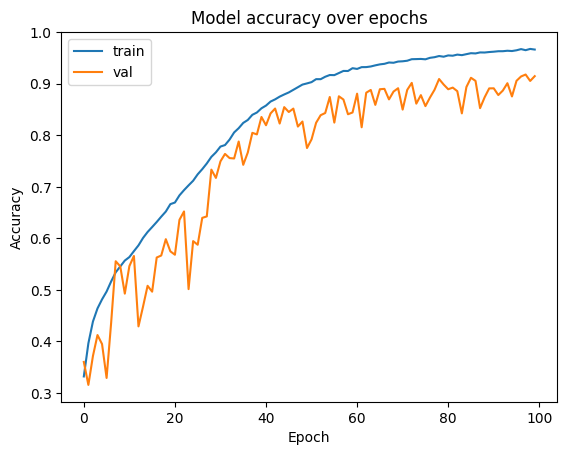

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('D:/BuzzNet/result/' + 'validation_accuracy.png', bbox_inches='tight', dpi=900)
plt.show()


### Confusion matrix and metrics

In [17]:
nb_batches = len(val_gen)
X_val = np.empty((nb_batches, batch_size, frame_length, 1))
y_val = np.empty((nb_batches, batch_size))

for i in range(nb_batches):
    X_val[i], y_val[i] = val_gen.__getitem__(i)

X_val = X_val.reshape((nb_batches * batch_size, -1))
y_val = y_val.reshape(nb_batches * batch_size)

y_val_actual = np.argmax(buzznet_model.predict(X_val), axis=-1)

208/208 [==============================] - 3s 11ms/step


In [18]:
from sklearn.metrics import precision_recall_fscore_support

p, r, f1, _ = precision_recall_fscore_support(y_val,
                                              y_val_actual,
                                              average='macro',
                                              zero_division=0)

print("Precision:", p)
print("Recall:", r)
print("F1 score:", f1)

Precision: 0.9121208996223931
Recall: 0.9131174236283601
F1 score: 0.9121410804840052


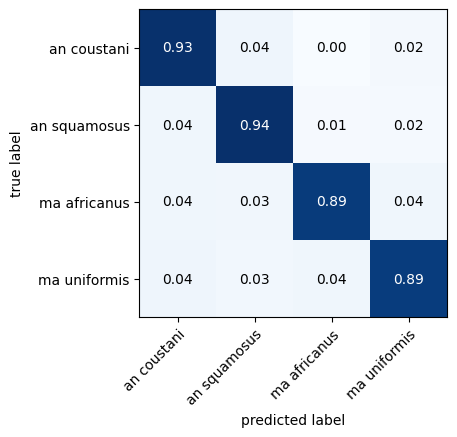

In [31]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_val, y_val_actual)

plot_confusion_matrix(cm,
                      show_normed=True,
                      show_absolute=False,
                      figsize=(4, 4),
                      class_names=['an coustani', 'an squamosus', 'ma africanus', 'ma uniformis'],
                      hide_ticks=False)
plt.savefig('D:/BuzzNet/result/' + 'confusionMatrix.png', bbox_inches='tight', dpi=900)

### Model Evaluation on the test set

In [20]:
test_loss, test_accuracy = buzznet_model.evaluate(test_gen)

print("Loss on Test set:", test_loss)
print("Accuracy on Test set:", test_accuracy)

52/52 [==============================] - 10s 185ms/step - loss: 0.3933 - accuracy: 0.9013
Loss on Test set: 0.39328324794769287
Accuracy on Test set: 0.901292085647583


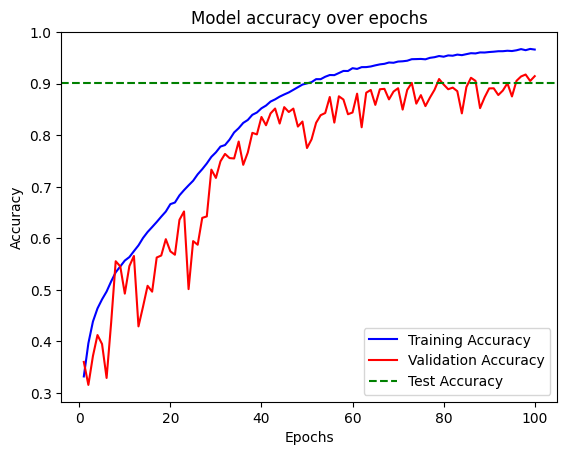

In [35]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range of epochs for x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plot training, validation, and test accuracy
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
plt.title('Model accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('D:/BuzzNet/result/' + 'test_accuracy.png', bbox_inches='tight', dpi=900)
plt.show()